# 3: Image Distortion and Undistortion

In the last [session](02_understanding_camera_models.ipynb) we looked at how we can use the camera matrix (K):

$$K = \left[\begin{array}{ccc} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{array}\right]$$

and the distortion coefficients (kc):

- Radial distortion: $k_1$ to $k_6$
- Tangential distortion: $p_1$ and $p_2$
- Thin prism distortion: $s_1$ to $s_4$
- Tilt distortion: $\tau_x$ and $\tau_y$

to model a camera, and how we can use this model to move between image (2D) space and world (3D) space:

::::{margin}
:::{warning}
When we do normalizations and distortions we usually omit the 3rd dimension, keeping only:

$$\left[\begin{array}{cc} x^* \\ y^*\end{array}\right]$$

This is because the 3rd dimension is always 1, but it's important that we remember that it's there.
:::
::::

$$
\left[\begin{array}{cc} x \\ y \end{array}\right] \xrightarrow[K]{\mathrm{normalize}}
\left[\begin{array}{cc} x' \\ y' \\ 1\end{array}\right] \xrightarrow[kc]{\mathrm{distort}}
\left[\begin{array}{cc} x^* \\ y^* \\ 1\end{array}\right]
$$

In this session we will look at how we can undistort instead of distorting. The reality is that when we want to work on 3D cameras, the images are already distorted. We want to undistort them to get the correct vectors:

$$
\left[\begin{array}{cc} x \\ y \end{array}\right] \xrightarrow[K]{\mathrm{normalize}}
\left[\begin{array}{cc} x' \\ y' \\ 1\end{array}\right] \xrightarrow[kc]{\mathrm{undistort}}
\left[\begin{array}{cc} x'' \\ y'' \\ 1\end{array}\right]
$$

Before we start I want to show an example of why this is important, during projections. We will look more at projection in the next session, but for now let's look at a simple example. Assume you have a 3D coordinate:

$$\left[\begin{array}{cc} X \\ Y \\ Z \end{array}\right]$$

How can we figure out where this point would be seen in the image? We now actually have a straight forward approach:

$$
\left[\begin{array}{cc} X \\ Y \\ Z \end{array}\right] \xrightarrow[Z]{\mathrm{divide}}
\left[\begin{array}{cc} \frac{X}{Z} \\ \frac{Y}{Z} \\ 1\end{array}\right] \xrightarrow[kc]{\mathrm{distort}}
\left[\begin{array}{cc} x' \\ y' \\ 1\end{array}\right] \xrightarrow[K]{\mathrm{denormalize}}
\left[\begin{array}{cc} x \\ y\end{array}\right]
$$



:::{note}
OpenCV uses the following order for the distortion coefficients: 

kc = [$k_1$, $k_2$, $p_1$, $p_2$[, $k_3$[, $k_4$, $k_5$, $k_6$[, $s_1$, $s_2$, $s_3$, $s_4$[, $\tau_x$, $\tau_y$]]]]]

Be careful about this if you want to use OpenCV functions.
:::


## Undistortion

Going back to the 5 parameter model we looked at in [session 2](02_understanding_camera_models.ipynb), we can see that the distortion is a function of the normalized pixel coordinates:

$$\begin{align*} x_d &= x(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + 2p_1 x y + p_2(r^2 + 2x^2) \\ y_d &= y(1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + p_1(r^2 + 2y^2) + 2p_2 x y \end{align*}$$

where $r^2 = x^2 + y^2$, and $x$ and $y$ are the normalized pixel coordinates. We can see that the distortion is a function of the normalized pixel coordinates, and that the distortion is a non-linear function of the pixel coordinates. This means that we can not simply invert the distortion function to get the undistorted pixel coordinates. Instead we need to find a different way to undistort the image.

Let's first create a reference grid of pixel values and a reference [lens model](../oaf_vision_3d/lens_model.py). We plot the resulting grid:

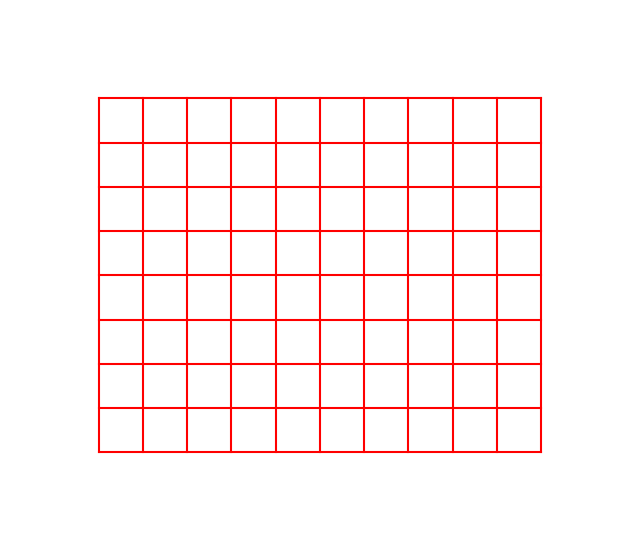

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add the parent directory of 'workshops' to sys.path
sys.path.append(os.path.abspath('..'))
from oaf_vision_3d.lens_model import CameraMatrix, DistortionCoefficients, LensModel


lens_model = LensModel(
    camera_matrix=CameraMatrix(
        fx=2500.0,
        fy=2500.0,
        cx=1250.0,
        cy=1000.0,
    ),
    distortion_coefficients=DistortionCoefficients(
        k1=0.3,
        k2=-0.1,
        p1=-0.02,
    ),
)

reference_pixels_grid = np.stack(
    np.meshgrid(
        np.linspace(0, 2499, 11),
        np.linspace(0, 1999, 9),
    ),
    axis=-1,
    dtype=np.float32,
)

plt.figure(figsize=(8, 10))
plt.plot(reference_pixels_grid[..., 0], reference_pixels_grid[..., 1], "-r")
plt.plot(reference_pixels_grid[..., 0].T, reference_pixels_grid[..., 1].T, "-r")
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

Next we can use the distortion function to distort the grid. We plot the distorted grid on top of the reference grid:

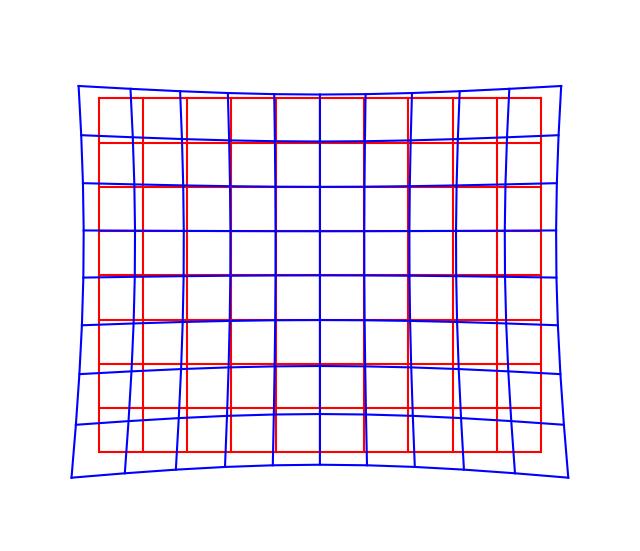

In [2]:
pixels_grid = lens_model.denormalize_pixels(
    lens_model.distort_pixels(lens_model.normalize_pixels(reference_pixels_grid))
)

plt.figure(figsize=(8, 10))
plt.plot(reference_pixels_grid[..., 0], reference_pixels_grid[..., 1], "-r")
plt.plot(reference_pixels_grid[..., 0].T, reference_pixels_grid[..., 1].T, "-r")
plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "-b")
plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "-b")
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

Our goal is to undistort the distorted grid. The result should be a grid that looks like the reference grid, of course we do not know the reference grid to compare with in normal cases. 

First, instead of plotting the grid, let's plot the change between the distorted and the reference grid. This will give us an idea of how the distortion looks:

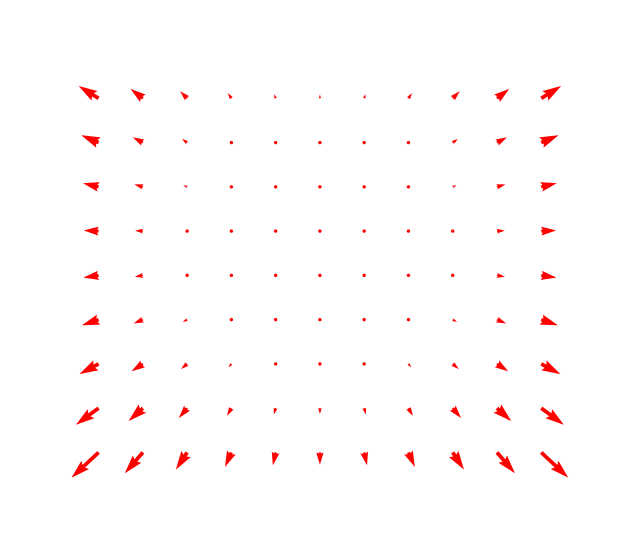

In [3]:
pixel_vector = pixels_grid - reference_pixels_grid

plt.figure(figsize=(8, 10))
plt.quiver(
    reference_pixels_grid[..., 0],
    reference_pixels_grid[..., 1],
    pixel_vector[..., 0],
    pixel_vector[..., 1],
    scale_units="xy",
    scale=1,
    color="r",
)
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

Since we have no way of directly undistorting, what happens if we just distort again?

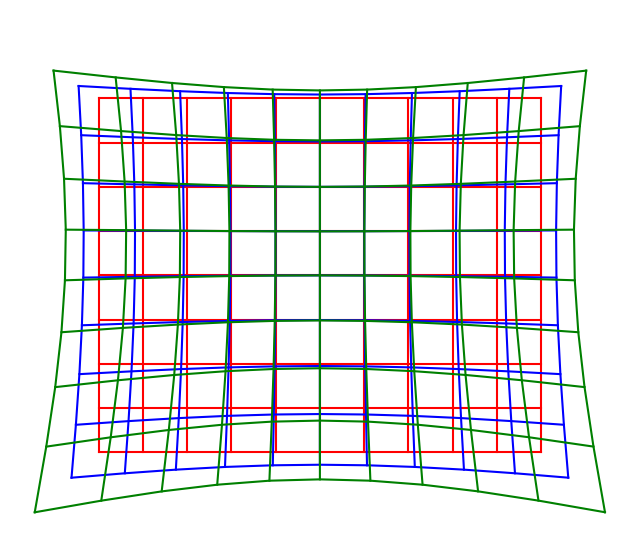

In [4]:
distorted_pixels_grid = lens_model.denormalize_pixels(
    lens_model.distort_pixels(lens_model.normalize_pixels(pixels_grid))
)

plt.figure(figsize=(8, 10))
plt.plot(reference_pixels_grid[..., 0], reference_pixels_grid[..., 1], "-r")
plt.plot(reference_pixels_grid[..., 0].T, reference_pixels_grid[..., 1].T, "-r")
plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "-b")
plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "-b")
plt.plot(distorted_pixels_grid[..., 0], distorted_pixels_grid[..., 1], "-g")
plt.plot(distorted_pixels_grid[..., 0].T, distorted_pixels_grid[..., 1].T, "-g")
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

As we expect, it becomes even more distorted. Let's also take alook at quiver plot for both the distorted and the double distorted grid:

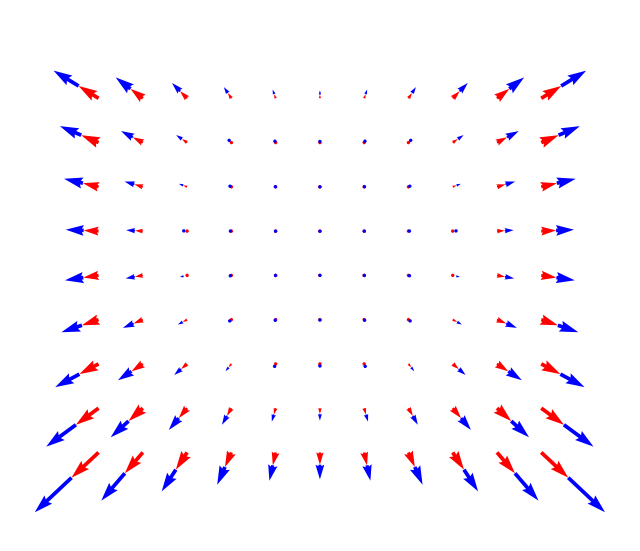

In [5]:
distorted_pixel_vector = distorted_pixels_grid - pixels_grid

plt.figure(figsize=(8, 10))
plt.quiver(
    reference_pixels_grid[..., 0],
    reference_pixels_grid[..., 1],
    pixel_vector[..., 0],
    pixel_vector[..., 1],
    scale_units="xy",
    scale=1,
    color="r",
)
plt.quiver(
    pixels_grid[..., 0],
    pixels_grid[..., 1],
    distorted_pixel_vector[..., 0],
    distorted_pixel_vector[..., 1],
    scale_units="xy",
    scale=1,
    color="b",
)
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

That's interesting! The change between the distorted and the double distorted grid is not the same as the change between the distorted and the reference grid, but it is close. What happens if we flip the arrows?

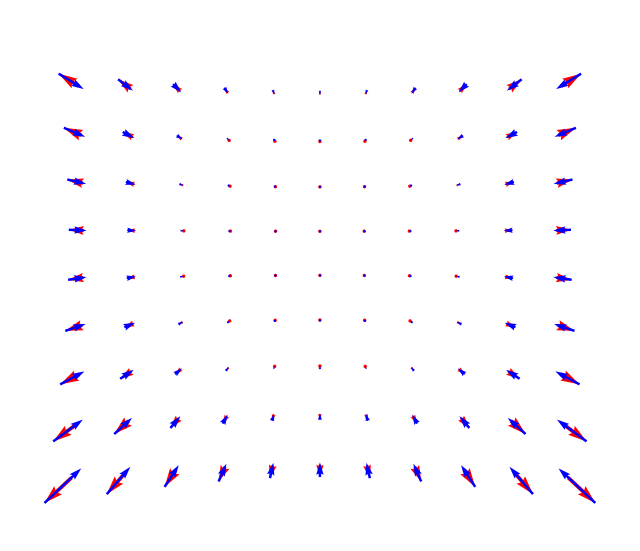

In [6]:
next_pixel_grid = pixels_grid + pixel_vector

plt.figure(figsize=(8, 10))
plt.quiver(
    pixels_grid[..., 0],
    pixels_grid[..., 1],
    pixel_vector[..., 0],
    pixel_vector[..., 1],
    scale_units="xy",
    scale=1,
    color="r",
)
plt.quiver(
    next_pixel_grid[..., 0],
    next_pixel_grid[..., 1],
    -distorted_pixel_vector[..., 0],
    -distorted_pixel_vector[..., 1],
    scale_units="xy",
    scale=1,
    color="b",
    width=0.004,
)
plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

We are not where we want to be, but we are closer. Let's also look at the grids:

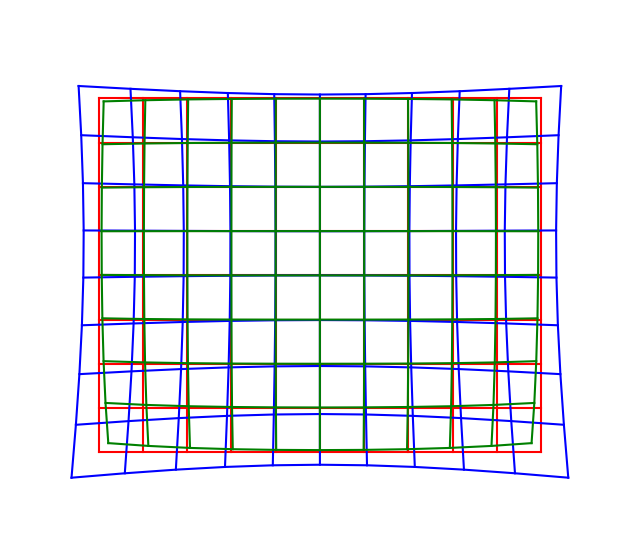

In [7]:
next_undistorted_pixel_grid = pixels_grid - distorted_pixel_vector

plt.figure(figsize=(8, 10))
plt.plot(reference_pixels_grid[..., 0], reference_pixels_grid[..., 1], "r-")
plt.plot(reference_pixels_grid[..., 0].T, reference_pixels_grid[..., 1].T, "r-")
plt.plot(pixels_grid[..., 0], pixels_grid[..., 1], "b-")
plt.plot(pixels_grid[..., 0].T, pixels_grid[..., 1].T, "b-")
plt.plot(next_undistorted_pixel_grid[..., 0], next_undistorted_pixel_grid[..., 1], "g-")
plt.plot(
    next_undistorted_pixel_grid[..., 0].T, next_undistorted_pixel_grid[..., 1].T, "g-"
)

plt.axis("image")
plt.axis("off")
plt.xlim(-500, 3000)
plt.ylim(-500, 2500)
plt.show()

You might already have guessed it, this is an iterative process. We can keep iterating until we are happy with the result. Let's do this:

In [8]:
from ipywidgets import interact, IntSlider

normalized_pixels = lens_model.normalize_pixels(pixels_grid)
undistorted_normalized_pixels = normalized_pixels.copy()

iterations = 10
iteration_results, errors = [pixels_grid], [
    np.sqrt(np.mean((pixels_grid - reference_pixels_grid) ** 2))
]
for _ in range(iterations):
    undistorted_normalized_pixels += normalized_pixels - lens_model.distort_pixels(
        undistorted_normalized_pixels
    )
    undistorted_pixels = lens_model.denormalize_pixels(
        undistorted_normalized_pixels.copy()
    )
    iteration_results.append(undistorted_pixels)
    errors.append(np.sqrt(np.mean((undistorted_pixels - reference_pixels_grid) ** 2)))


def plot_with_sliders(iteration: int) -> None:
    new_pixels_grid = iteration_results[iteration]
    error = errors[iteration]

    plt.figure(figsize=(8, 10))
    plt.plot(reference_pixels_grid[..., 0], reference_pixels_grid[..., 1], "-r")
    plt.plot(reference_pixels_grid[..., 0].T, reference_pixels_grid[..., 1].T, "-r")
    plt.plot(new_pixels_grid[..., 0], new_pixels_grid[..., 1], "-b")
    plt.plot(new_pixels_grid[..., 0].T, new_pixels_grid[..., 1].T, "-b")
    plt.axis("image")
    plt.axis("off")
    plt.xlim(-500, 2999)
    plt.ylim(2499, -500)
    plt.title(f"Curren RMS: {error:.03f} pixels")
    plt.show()


_ = interact(
    plot_with_sliders, iteration=IntSlider(min=0, max=iterations, step=1, value=0)
)

interactive(children=(IntSlider(value=0, description='iteration', max=10), Output()), _dom_classes=('widget-in…

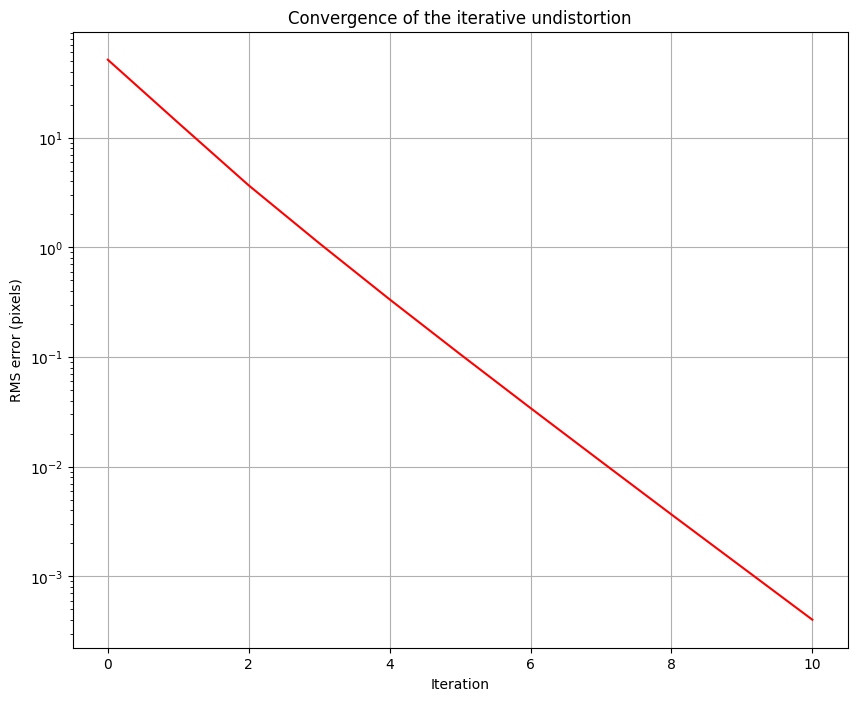

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(iterations + 1), errors, "-r")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("RMS error (pixels)")
plt.grid()
plt.title("Convergence of the iterative undistortion")
plt.show()

That was actually pretty straight forward, but what have we actually done? Let's define the different naming first:

- $x'$ and $y'$ are the normalized pixel coordinates, these coordinates are distorted since an image is "always" distorted.
- $x''$ and $y''$ are the undistorted normalized pixel coordinates, these are the coordinates we want to find.
- If we distort $x''$ and $y''$ we get $x'$ and $y'$.

We are now estimating that:

$$
\left[\begin{array}{cc} x'' \\ y'' \end{array}\right] - \left[\begin{array}{cc} x' \\ y' \end{array}\right] \approx
\left[\begin{array}{cc} x' \\ y' \end{array}\right] - \text{distort}\left(\left[\begin{array}{cc} x' \\ y' \end{array}\right]\right)
$$

To make it iterative we have to add som indices:

$$
\left[\begin{array}{cc} x''_n \\ y''_n \end{array}\right] - \left[\begin{array}{cc} x''_{n-1} \\ y''_{n-1} \end{array}\right] \approx
\left[\begin{array}{cc} x''_0 \\ y''_0 \end{array}\right] - \text{distort}\left(\left[\begin{array}{cc} x''_{n-1} \\ y''_{n-1} \end{array}\right]\right)
$$

and we choose the initial guess to $x''_0 = x'$ and $y''_0 = y'$. This gives us the following iterative process:

$$
\left[\begin{array}{cc} x''_n \\ y''_n \end{array}\right] = \left[\begin{array}{cc} x''_{n-1} \\ y''_{n-1} \end{array}\right] + \left[\begin{array}{cc} x''_0 \\ y''_0 \end{array}\right] - \text{distort}\left(\left[\begin{array}{cc} x''_{n-1} \\ y''_{n-1} \end{array}\right]\right)
$$

We can simplify this down to a simple equation:

$$
P_n = P_{n-1} + P_0 - \text{distort}(P_{n-1})
$$

where $P = [x, y]$ is the pixel coordinates and $P_0 = [x', y']$ is our initial guess. Let's implement this in a function:

In [10]:
from nptyping import Float32, NDArray, Shape

from oaf_vision_3d.lens_model import _distort_pixels as distort_pixels


def undistort_pixels(
    normalized_pixels: NDArray[Shape["H, W, 2"], Float32],
    distortion_coefficients: DistortionCoefficients,
    number_of_iterations: int = 10,
) -> NDArray[Shape["H, W, 2"], Float32]:
    undistorted_normalized_pixels = normalized_pixels.copy()
    for _ in range(number_of_iterations):
        undistorted_normalized_pixels += normalized_pixels - distort_pixels(
            normalized_pixels=undistorted_normalized_pixels,
            distortion_coefficients=distortion_coefficients,
        )
    return undistorted_normalized_pixels

:::{note}
It’s reasonable to ask: "If we want undistorted pixels, why are the models written from undistorted to distorted?" In practice, projections often work in reverse to address key problems. However, there are models designed the other way around (e.g., Halcon).
:::

## Creating an undistorted image

Now we can look at how we undistort an image, that is, if you have a distorted image like this:

![distorted](../test_data/checkerboard.png)

How can we undistort it to get this:

![undistorted](../test_data/undistorted_checkerboard.png)

Let's start by loading the image and the camera model:

In [11]:
from oaf_vision_3d._test_data_paths import TestDataPaths

image = plt.imread(str(TestDataPaths.distorted_checkerboard))
lens_model = LensModel.read_from_json(TestDataPaths.distorted_checkerboard_lens_model)

This is all we need to undistort the image, remember that the [lens model](../oaf_vision_3d/lens_model.py) has classmethods for normalizations and distortions. If we undistort the pixel index we get where that pixel should have been. Sadly this does not help us, since we cannot make an image with float value indices (this is what you do in a pointcloud). Instead we need to create a perfect pixel grid and distort it, this will tell us where in the image we are looking. We can then interpolate the pixel values to get the undistorted image. The step-by-step process is:

1. Create a perfect pixel grid. (Hint: `np.indices`)
2. Distort the pixel grid. (Hint: `normalize` -> `distort` -> `denormalize`)
3. Interpolate the pixel values. (Hint: `scipy.ndimage.map_coordinates`)

The resulting image should be the undistorted image. Let's implement this:

In [12]:
from scipy.ndimage import map_coordinates


def undistort_image(
    image: NDArray[Shape["H, W, 3"], Float32], lens_model: LensModel
) -> NDArray[Shape["H, W, 3"], Float32]:
    y, x = np.indices(image.shape[:2])
    pixels = np.stack([x, y], axis=-1)
    normalized_pixels = lens_model.normalize_pixels(pixels=pixels)
    distorted_normalized_pixels = lens_model.distort_pixels(
        normalized_pixels=normalized_pixels
    )
    distorted_pixels = lens_model.denormalize_pixels(pixels=distorted_normalized_pixels)

    undistorted_image = np.stack(
        [
            map_coordinates(
                input=_image,
                coordinates=[distorted_pixels[..., 1], distorted_pixels[..., 0]],
                order=1,
            )
            for _image in image.transpose(2, 0, 1)
        ],
        axis=-1,
    )
    return undistorted_image.astype(np.float32)

Let's see if it works:

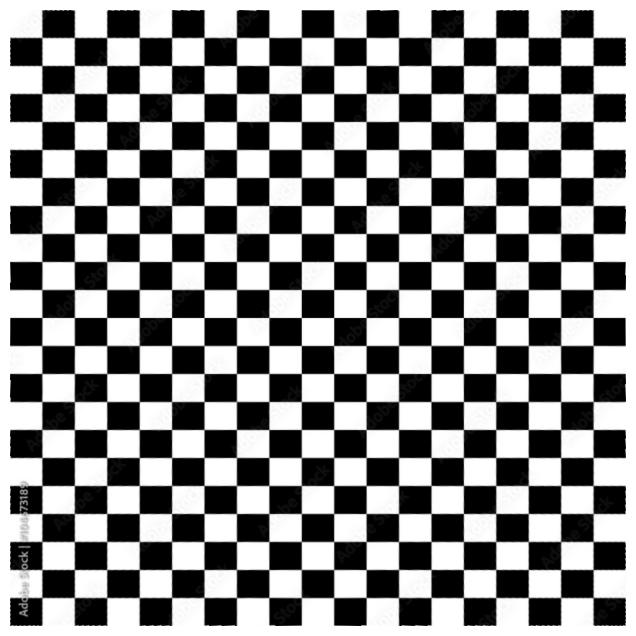

In [13]:
undistorted_image = undistort_image(image=image, lens_model=lens_model)

plt.figure(figsize=(10, 8))
plt.imshow(undistorted_image)
plt.axis("off")
plt.show()

### New camera matrix

When we undistort an image also change what is visible in the image. In the image above we have actually cropped away all the white around the checkerboard. In this case it is not a problem, but what if there are information that we want to keep? Let's take a look at the following image:

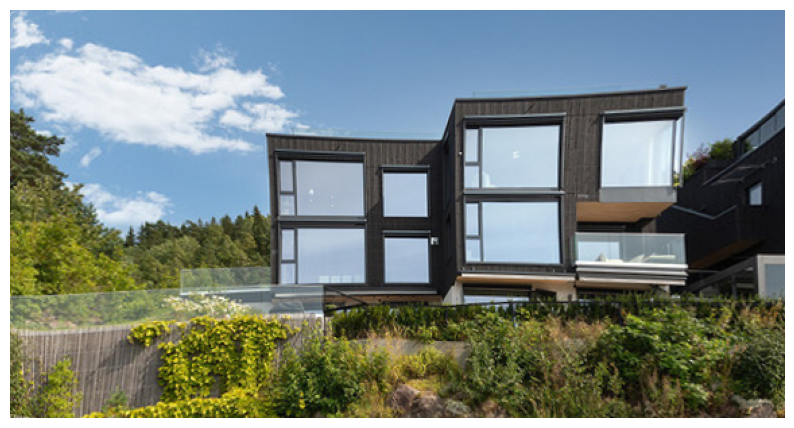

In [14]:
image_house = plt.imread(str(TestDataPaths.distorted_house))
lens_model_house = LensModel.read_from_json(TestDataPaths.distorted_house_lens_model)

plt.figure(figsize=(10, 8))
plt.imshow(image_house)
plt.axis("off")
plt.show()

When we undistort the image we get:

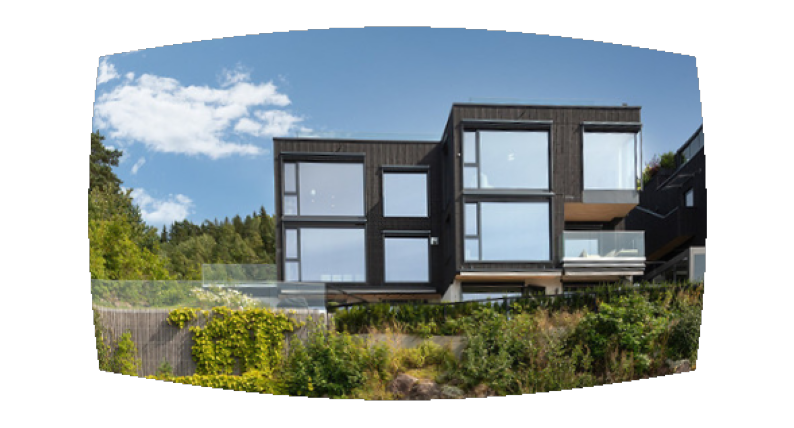

In [15]:
undistorted_image_house = undistort_image(
    image=image_house, lens_model=lens_model_house
)

plt.figure(figsize=(10, 8))
plt.imshow(undistorted_image_house)
plt.axis("off")
plt.show()

I'll leave it up to you to solve this problem, but I'll give you a hint. The camera matrix is the key to this problem, and you can use the camera matrix to change the size of the image. But be careful, you should only change the camera matrix on the normalization step, not the denormalization step. OpenCV has a function for this, `cv2.getOptimalNewCameraMatrix` that you could look into, but you still need to implement the logic.

In [16]:
from oaf_vision_3d.lens_model import normalize_pixels


def undistort_image_with_new_camera_matrix(
    image: NDArray[Shape["H, W, 3"], Float32],
    lens_model: LensModel,
    new_camera_matrix: CameraMatrix,
) -> NDArray[Shape["H, W, 3"], Float32]: 
    y, x = np.indices(image.shape[:2])
    pixels = np.stack([x, y], axis=-1)
    normalized_pixels = normalize_pixels(pixels=pixels,camera_matrix=new_camera_matrix)
    distorted_normalized_pixels = lens_model.distort_pixels(
        normalized_pixels=normalized_pixels
    )
    distorted_pixels = lens_model.denormalize_pixels(pixels=distorted_normalized_pixels)

    undistorted_image = np.stack(
        [
            map_coordinates(
                input=_image,
                coordinates=[distorted_pixels[..., 1], distorted_pixels[..., 0]],
                order=1,
            )
            for _image in image.transpose(2, 0, 1)
        ],
        axis=-1,
    )
    return undistorted_image.astype(np.float32)

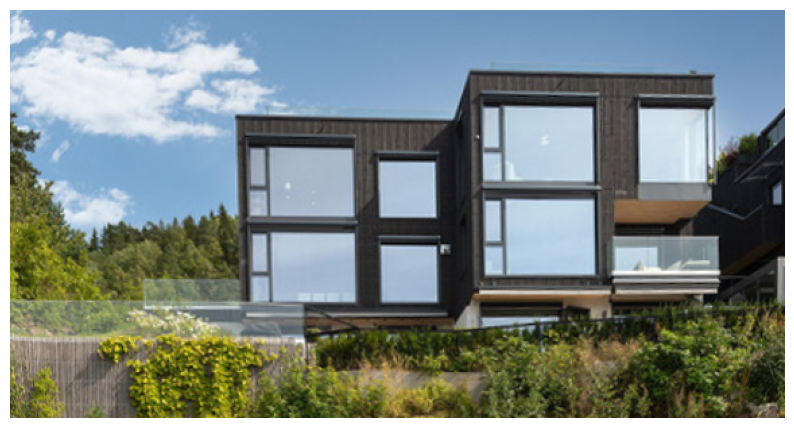

In [17]:
scale = 1.3
new_camera_matrix = CameraMatrix(
    fx=lens_model_house.camera_matrix.fx * scale,
    fy=lens_model_house.camera_matrix.fy * scale,
    cx=lens_model_house.camera_matrix.cx,
    cy=lens_model_house.camera_matrix.cy,
)

new_undistorted_image_house = undistort_image_with_new_camera_matrix(
    image=image_house, lens_model=lens_model_house, new_camera_matrix=new_camera_matrix
)

if new_undistorted_image_house is not None:
    plt.figure(figsize=(10, 8))
    plt.imshow(new_undistorted_image_house)
    plt.axis("off")
    plt.show()

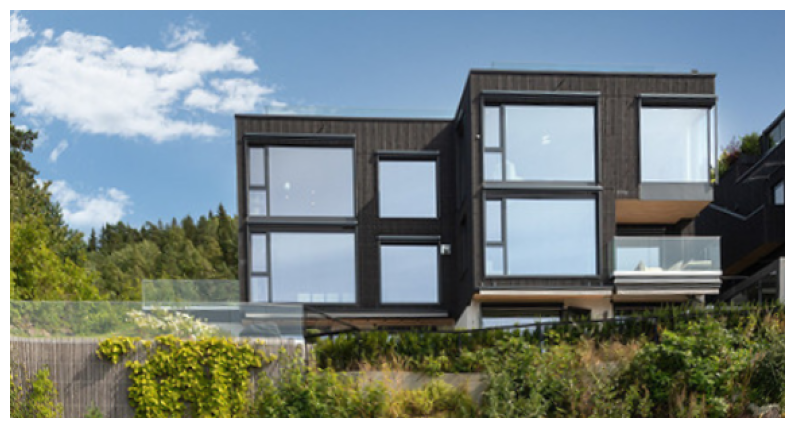

In [18]:
import cv2


new_camera_matrix, _ = cv2.getOptimalNewCameraMatrix(
    cameraMatrix=lens_model_house.camera_matrix.as_matrix(),
    distCoeffs=lens_model_house.distortion_coefficients.as_opencv_vector(),
    imageSize=image_house.shape[:2][::-1],
    alpha=0,
)

new_undistorted_image_house = undistort_image_with_new_camera_matrix(
    image=image_house,
    lens_model=lens_model_house,
    new_camera_matrix=CameraMatrix.from_matrix(
        np.array(new_camera_matrix, dtype=np.float32)
    ),
)

if new_undistorted_image_house is not None:
    plt.figure(figsize=(10, 8))
    plt.imshow(new_undistorted_image_house)
    plt.axis("off")
    plt.show()